In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [4]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/nCars_train_EST_exp_", transform=transforms)
test_data = NCarsImageDataset("./Datasety/nCars_test_EST_exp_", transform=transforms)



In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0,max_val=1,inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = self.relu(out)
        else:
            out = self.relu(out)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.0025, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                regularization_loss = 0
                for param in self.parameters():
                    regularization_loss += torch.sum(torch.abs(param))
                loss = criterion(outputs, labels) + 0.0001*regularization_loss
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_ReLU_ReLU1_ReLUmaxpool_EST_FC2__128x128_pretrained_aug_correct_exp_mixed_L1_L2.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 12).to("cuda")


In [9]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): Batch

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

### Copy of a weights

In [12]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=

In [13]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [14]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 3.8650e-02, -2.4755e-02,  3.1336e-02,  ..., -2.3414e-02,
           -3.1408e-02, -1.1406e-02],
          [-3.9863e-02,  2.8894e-02,  3.8102e-02,  ..., -1.6937e-02,
           -3.9084e-02, -3.3890e-02],
          [-9.8872e-04, -3.4150e-02,  6.7574e-03,  ...,  1.8900e-02,
           -5.7330e-03, -1.8446e-02],
          ...,
          [-3.1852e-02, -7.9597e-03,  3.4045e-02,  ...,  3.6270e-02,
            3.9743e-02, -1.0917e-02],
          [-2.2834e-02, -3.5158e-02, -2.5911e-03,  ...,  3.4277e-02,
           -2.5279e-03,  1.2041e-03],
          [-2.3344e-02, -2.4968e-02, -4.0940e-02,  ...,  1.2931e-02,
           -2.7469e-02, -4.9260e-05]],

         [[ 1.7249e-02,  8.6458e-03, -1.4963e-03,  ..., -3.1229e-02,
           -3.7942e-02, -2.8588e-02],
          [-5.8885e-03, -4.7952e-03,  8.2701e-03,  ...,  7.0448e-03,
            3.4330e-02,  8.5589e-03],
          [ 8.7839e-03, -1.1962e-02, -2.1155e-02,  ...,  1.9892e-02,
            1.7430e-02,  1.0410e-02]

In [15]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

100%|██████████| 482/482 [02:13<00:00,  3.61it/s]


Epoch [1/120], Step [482/482], Loss: 14.9708, Accuracy: 0.6576
Accuracy of the network: 70.93063785291042 Loss: 0.6019695359091777%


100%|██████████| 482/482 [02:11<00:00,  3.66it/s]


Epoch [2/120], Step [482/482], Loss: 3.4658, Accuracy: 0.8217
Accuracy of the network: 78.49424886720112 Loss: 0.49811802494260016%


100%|██████████| 482/482 [02:19<00:00,  3.46it/s]


Epoch [3/120], Step [482/482], Loss: 3.1036, Accuracy: 0.8542
Accuracy of the network: 84.51260601835715 Loss: 0.37251498425538654%


100%|██████████| 482/482 [02:21<00:00,  3.40it/s]


Epoch [4/120], Step [482/482], Loss: 2.9344, Accuracy: 0.8667
Accuracy of the network: 83.42047170907401 Loss: 0.4202328623449049%


100%|██████████| 482/482 [02:07<00:00,  3.77it/s]


Epoch [5/120], Step [482/482], Loss: 2.8060, Accuracy: 0.8699
Accuracy of the network: 81.0270709887301 Loss: 0.41878593826604155%


100%|██████████| 482/482 [02:08<00:00,  3.76it/s]


Epoch [6/120], Step [482/482], Loss: 2.7194, Accuracy: 0.8809
Accuracy of the network: 84.57069826885093 Loss: 0.3674599918014055%


100%|██████████| 482/482 [02:07<00:00,  3.77it/s]


Epoch [7/120], Step [482/482], Loss: 2.5262, Accuracy: 0.8872
Accuracy of the network: 85.55826652724527 Loss: 0.3452357917359327%


100%|██████████| 482/482 [02:10<00:00,  3.69it/s]


Epoch [8/120], Step [482/482], Loss: 2.4388, Accuracy: 0.8873
Accuracy of the network: 83.54827466016033 Loss: 0.39429300048537413%


100%|██████████| 482/482 [02:11<00:00,  3.67it/s]


Epoch [9/120], Step [482/482], Loss: 2.3113, Accuracy: 0.8912
Accuracy of the network: 81.34076914139654 Loss: 0.43235090361097933%


100%|██████████| 482/482 [02:12<00:00,  3.64it/s]


Epoch [10/120], Step [482/482], Loss: 2.2271, Accuracy: 0.8882
Accuracy of the network: 82.68850935285234 Loss: 0.40074525297131236%


100%|██████████| 482/482 [02:10<00:00,  3.70it/s]


Epoch [11/120], Step [482/482], Loss: 2.1034, Accuracy: 0.8966
Accuracy of the network: 85.55826652724527 Loss: 0.3364525024110943%


100%|██████████| 482/482 [02:12<00:00,  3.64it/s]


Epoch [12/120], Step [482/482], Loss: 1.9790, Accuracy: 0.8961
Accuracy of the network: 85.8719646799117 Loss: 0.39296549060087665%


100%|██████████| 482/482 [02:12<00:00,  3.63it/s]


Epoch [13/120], Step [482/482], Loss: 1.9246, Accuracy: 0.9019
Accuracy of the network: 83.95492041361682 Loss: 0.37819056822243236%


100%|██████████| 482/482 [02:05<00:00,  3.85it/s]


Epoch [14/120], Step [482/482], Loss: 1.8138, Accuracy: 0.9036
Accuracy of the network: 89.00894620657604 Loss: 0.2670982309433607%


100%|██████████| 482/482 [02:09<00:00,  3.74it/s]


Epoch [15/120], Step [482/482], Loss: 1.6927, Accuracy: 0.9046
Accuracy of the network: 83.15324735680261 Loss: 0.42889548854756976%


100%|██████████| 482/482 [02:08<00:00,  3.77it/s]


Epoch [16/120], Step [482/482], Loss: 1.6332, Accuracy: 0.9075
Accuracy of the network: 83.09515510630882 Loss: 0.3787483428102887%


100%|██████████| 482/482 [02:06<00:00,  3.80it/s]


Epoch [17/120], Step [482/482], Loss: 1.5413, Accuracy: 0.9140
Accuracy of the network: 86.49936098524456 Loss: 0.3242281315273512%


100%|██████████| 482/482 [02:04<00:00,  3.88it/s]


Epoch [18/120], Step [482/482], Loss: 1.4746, Accuracy: 0.9125
Accuracy of the network: 83.16486580690136 Loss: 0.4240168770671334%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [19/120], Step [482/482], Loss: 1.4080, Accuracy: 0.9178
Accuracy of the network: 86.67363773672592 Loss: 0.3246718127432809%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [20/120], Step [482/482], Loss: 1.3218, Accuracy: 0.9220
Accuracy of the network: 86.85953293830603 Loss: 0.3206403615250907%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [21/120], Step [482/482], Loss: 1.2817, Accuracy: 0.9180
Accuracy of the network: 87.26617869176252 Loss: 0.31677919058440784%


100%|██████████| 482/482 [01:56<00:00,  4.13it/s]


Epoch [22/120], Step [482/482], Loss: 1.2133, Accuracy: 0.9221
Accuracy of the network: 87.68444289531776 Loss: 0.30118594846262364%


100%|██████████| 482/482 [01:54<00:00,  4.22it/s]


Epoch [23/120], Step [482/482], Loss: 1.1366, Accuracy: 0.9206
Accuracy of the network: 87.75415359591031 Loss: 0.29526961229215326%


100%|██████████| 482/482 [01:54<00:00,  4.21it/s]


Epoch [24/120], Step [482/482], Loss: 1.0794, Accuracy: 0.9286
Accuracy of the network: 87.53340304403393 Loss: 0.32742721631735233%


100%|██████████| 482/482 [01:57<00:00,  4.10it/s]


Epoch [25/120], Step [482/482], Loss: 1.0224, Accuracy: 0.9273
Accuracy of the network: 78.22702451492971 Loss: 0.5668037050164765%


100%|██████████| 482/482 [01:55<00:00,  4.16it/s]


Epoch [26/120], Step [482/482], Loss: 0.9846, Accuracy: 0.9275
Accuracy of the network: 89.99651446497037 Loss: 0.24277325309674536%


100%|██████████| 482/482 [01:43<00:00,  4.67it/s]


Epoch [27/120], Step [482/482], Loss: 0.9479, Accuracy: 0.9272
Accuracy of the network: 88.79981410479841 Loss: 0.27289564546100714%


100%|██████████| 482/482 [02:03<00:00,  3.91it/s]


Epoch [28/120], Step [482/482], Loss: 0.8795, Accuracy: 0.9343
Accuracy of the network: 89.19484140815615 Loss: 0.27498405074292176%


100%|██████████| 482/482 [01:40<00:00,  4.77it/s]


Epoch [29/120], Step [482/482], Loss: 0.8418, Accuracy: 0.9328
Accuracy of the network: 89.39235505983501 Loss: 0.27542942461858894%


100%|██████████| 482/482 [01:56<00:00,  4.14it/s]


Epoch [30/120], Step [482/482], Loss: 0.7980, Accuracy: 0.9369
Accuracy of the network: 89.52015801092135 Loss: 0.2591885880439033%


100%|██████████| 482/482 [01:57<00:00,  4.11it/s]


Epoch [31/120], Step [482/482], Loss: 0.7631, Accuracy: 0.9382
Accuracy of the network: 88.66039270361334 Loss: 0.29166683467402776%


100%|██████████| 482/482 [01:56<00:00,  4.13it/s]


Epoch [32/120], Step [482/482], Loss: 0.7345, Accuracy: 0.9413
Accuracy of the network: 89.8803299639828 Loss: 0.26038696640430775%


100%|██████████| 482/482 [01:47<00:00,  4.47it/s]


Epoch [33/120], Step [482/482], Loss: 0.6966, Accuracy: 0.9405
Accuracy of the network: 90.77495062158708 Loss: 0.24096468441382216%


100%|██████████| 482/482 [01:56<00:00,  4.13it/s]


Epoch [34/120], Step [482/482], Loss: 0.6680, Accuracy: 0.9416
Accuracy of the network: 90.62391077030324 Loss: 0.2558559507519339%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [35/120], Step [482/482], Loss: 0.6341, Accuracy: 0.9458
Accuracy of the network: 89.52015801092135 Loss: 0.27166423304041076%


100%|██████████| 482/482 [01:58<00:00,  4.06it/s]


Epoch [36/120], Step [482/482], Loss: 0.6089, Accuracy: 0.9462
Accuracy of the network: 91.26292552573487 Loss: 0.22286264735471362%


100%|██████████| 482/482 [02:00<00:00,  4.00it/s]


Epoch [37/120], Step [482/482], Loss: 0.5766, Accuracy: 0.9510
Accuracy of the network: 89.64796096200767 Loss: 0.2614789032221505%


100%|██████████| 482/482 [01:57<00:00,  4.10it/s]


Epoch [38/120], Step [482/482], Loss: 0.5551, Accuracy: 0.9494
Accuracy of the network: 90.3683048681306 Loss: 0.24150588332941983%


100%|██████████| 482/482 [01:55<00:00,  4.19it/s]


Epoch [39/120], Step [482/482], Loss: 0.5355, Accuracy: 0.9487
Accuracy of the network: 90.86789822237714 Loss: 0.23917117311885808%


100%|██████████| 482/482 [01:55<00:00,  4.18it/s]


Epoch [40/120], Step [482/482], Loss: 0.5161, Accuracy: 0.9490
Accuracy of the network: 90.07784361566168 Loss: 0.2450251756547552%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [41/120], Step [482/482], Loss: 0.4956, Accuracy: 0.9506
Accuracy of the network: 89.85709306378529 Loss: 0.2681554339161371%


100%|██████████| 482/482 [01:53<00:00,  4.23it/s]


Epoch [42/120], Step [482/482], Loss: 0.4609, Accuracy: 0.9551
Accuracy of the network: 91.01893807366098 Loss: 0.24131035630947817%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [43/120], Step [482/482], Loss: 0.4465, Accuracy: 0.9555
Accuracy of the network: 90.28697571743929 Loss: 0.25167632230374004%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [44/120], Step [482/482], Loss: 0.4372, Accuracy: 0.9534
Accuracy of the network: 91.30939932612989 Loss: 0.22744007367072938%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [45/120], Step [482/482], Loss: 0.4127, Accuracy: 0.9556
Accuracy of the network: 91.18159637504357 Loss: 0.23270138396732648%


100%|██████████| 482/482 [01:52<00:00,  4.27it/s]


Epoch [46/120], Step [482/482], Loss: 0.3968, Accuracy: 0.9586
Accuracy of the network: 91.47205762751248 Loss: 0.22613287877748448%


100%|██████████| 482/482 [01:53<00:00,  4.26it/s]


Epoch [47/120], Step [482/482], Loss: 0.3802, Accuracy: 0.9584
Accuracy of the network: 90.63552922040199 Loss: 0.24195743415878607%


100%|██████████| 482/482 [01:54<00:00,  4.22it/s]


Epoch [48/120], Step [482/482], Loss: 0.3664, Accuracy: 0.9597
Accuracy of the network: 91.03055652375973 Loss: 0.2214250841825425%


100%|██████████| 482/482 [01:53<00:00,  4.24it/s]


Epoch [49/120], Step [482/482], Loss: 0.3534, Accuracy: 0.9594
Accuracy of the network: 90.83304287208087 Loss: 0.23697875899203868%


100%|██████████| 482/482 [01:57<00:00,  4.11it/s]


Epoch [50/120], Step [482/482], Loss: 0.3374, Accuracy: 0.9586
Accuracy of the network: 91.30939932612989 Loss: 0.23124975130848283%


100%|██████████| 482/482 [02:03<00:00,  3.90it/s]


Epoch [51/120], Step [482/482], Loss: 0.3236, Accuracy: 0.9597
Accuracy of the network: 91.48367607761125 Loss: 0.22339983953363834%


100%|██████████| 482/482 [01:58<00:00,  4.07it/s]


Epoch [52/120], Step [482/482], Loss: 0.3082, Accuracy: 0.9619
Accuracy of the network: 90.8214244219821 Loss: 0.24558153657803528%


100%|██████████| 482/482 [01:58<00:00,  4.07it/s]


Epoch [53/120], Step [482/482], Loss: 0.2996, Accuracy: 0.9614
Accuracy of the network: 90.70523992099454 Loss: 0.24439912186900922%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [54/120], Step [482/482], Loss: 0.2935, Accuracy: 0.9613
Accuracy of the network: 91.2513070756361 Loss: 0.22402429215776212%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [55/120], Step [482/482], Loss: 0.2765, Accuracy: 0.9641
Accuracy of the network: 91.18159637504357 Loss: 0.23588264842957368%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [56/120], Step [482/482], Loss: 0.2665, Accuracy: 0.9655
Accuracy of the network: 91.30939932612989 Loss: 0.2270601255244482%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [57/120], Step [482/482], Loss: 0.2572, Accuracy: 0.9656
Accuracy of the network: 91.44882072731498 Loss: 0.2296684468476635%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [58/120], Step [482/482], Loss: 0.2463, Accuracy: 0.9684
Accuracy of the network: 91.34425467642616 Loss: 0.2392096618972857%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [59/120], Step [482/482], Loss: 0.2370, Accuracy: 0.9682
Accuracy of the network: 91.72766352968515 Loss: 0.21808117207790617%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [60/120], Step [482/482], Loss: 0.2324, Accuracy: 0.9672
Accuracy of the network: 92.1691646334379 Loss: 0.2161639932453023%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [61/120], Step [482/482], Loss: 0.2271, Accuracy: 0.9661
Accuracy of the network: 91.66957127919136 Loss: 0.22010568653312979%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [62/120], Step [482/482], Loss: 0.2168, Accuracy: 0.9691
Accuracy of the network: 90.70523992099454 Loss: 0.23595735672376633%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [63/120], Step [482/482], Loss: 0.2116, Accuracy: 0.9684
Accuracy of the network: 91.97165098175903 Loss: 0.21296236047791284%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [64/120], Step [482/482], Loss: 0.2021, Accuracy: 0.9709
Accuracy of the network: 92.12269083304287 Loss: 0.20846133883765527%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [65/120], Step [482/482], Loss: 0.1977, Accuracy: 0.9694
Accuracy of the network: 91.69280817938888 Loss: 0.21856861511681602%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [66/120], Step [482/482], Loss: 0.1888, Accuracy: 0.9729
Accuracy of the network: 91.75090042988265 Loss: 0.2221514476830188%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [67/120], Step [482/482], Loss: 0.1862, Accuracy: 0.9706
Accuracy of the network: 91.86708493087022 Loss: 0.21923879680109512%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [68/120], Step [482/482], Loss: 0.1774, Accuracy: 0.9706
Accuracy of the network: 92.7617055884745 Loss: 0.20414304775514788%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [69/120], Step [482/482], Loss: 0.1715, Accuracy: 0.9722
Accuracy of the network: 92.6803764377832 Loss: 0.19357866868653706%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [70/120], Step [482/482], Loss: 0.1712, Accuracy: 0.9708
Accuracy of the network: 92.6803764377832 Loss: 0.20149863892162156%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [71/120], Step [482/482], Loss: 0.1657, Accuracy: 0.9733
Accuracy of the network: 92.63390263738818 Loss: 0.20880431932185994%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [72/120], Step [482/482], Loss: 0.1628, Accuracy: 0.9732
Accuracy of the network: 92.34344138491925 Loss: 0.19875191645108192%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [73/120], Step [482/482], Loss: 0.1575, Accuracy: 0.9733
Accuracy of the network: 92.55257348669687 Loss: 0.20153133431968856%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [74/120], Step [482/482], Loss: 0.1489, Accuracy: 0.9754
Accuracy of the network: 92.13430928314163 Loss: 0.20627257148960265%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [75/120], Step [482/482], Loss: 0.1483, Accuracy: 0.9740
Accuracy of the network: 92.79656093877077 Loss: 0.1990999328907316%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [76/120], Step [482/482], Loss: 0.1419, Accuracy: 0.9741
Accuracy of the network: 92.49448123620309 Loss: 0.21578612567711497%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [77/120], Step [482/482], Loss: 0.1405, Accuracy: 0.9745
Accuracy of the network: 92.4131520855118 Loss: 0.2045328512123083%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [78/120], Step [482/482], Loss: 0.1388, Accuracy: 0.9741
Accuracy of the network: 91.91355873126525 Loss: 0.2129152244213124%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [79/120], Step [482/482], Loss: 0.1323, Accuracy: 0.9752
Accuracy of the network: 92.54095503659812 Loss: 0.20655347784932662%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [80/120], Step [482/482], Loss: 0.1288, Accuracy: 0.9754
Accuracy of the network: 92.99407459044963 Loss: 0.20036796723115066%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [81/120], Step [482/482], Loss: 0.1263, Accuracy: 0.9772
Accuracy of the network: 92.40153363541303 Loss: 0.21731124320465614%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [82/120], Step [482/482], Loss: 0.1259, Accuracy: 0.9769
Accuracy of the network: 93.08702219123968 Loss: 0.187752246157332%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [83/120], Step [482/482], Loss: 0.1218, Accuracy: 0.9765
Accuracy of the network: 92.45962588590682 Loss: 0.20579115043785493%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [84/120], Step [482/482], Loss: 0.1196, Accuracy: 0.9749
Accuracy of the network: 92.66875798768444 Loss: 0.19920523431442927%


100%|██████████| 482/482 [01:58<00:00,  4.08it/s]


Epoch [85/120], Step [482/482], Loss: 0.1174, Accuracy: 0.9767
Accuracy of the network: 92.72685023817823 Loss: 0.20317283547292966%


100%|██████████| 482/482 [01:57<00:00,  4.09it/s]


Epoch [86/120], Step [482/482], Loss: 0.1144, Accuracy: 0.9769
Accuracy of the network: 92.71523178807946 Loss: 0.20629812103304943%


100%|██████████| 482/482 [01:56<00:00,  4.12it/s]


Epoch [87/120], Step [482/482], Loss: 0.1129, Accuracy: 0.9777
Accuracy of the network: 93.09864064133845 Loss: 0.1997864871981751%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [88/120], Step [482/482], Loss: 0.1103, Accuracy: 0.9774
Accuracy of the network: 92.97083769025213 Loss: 0.1980245681098735%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [89/120], Step [482/482], Loss: 0.1105, Accuracy: 0.9781
Accuracy of the network: 92.58742883699314 Loss: 0.2112271159014848%


100%|██████████| 482/482 [01:04<00:00,  7.45it/s]


Epoch [90/120], Step [482/482], Loss: 0.1110, Accuracy: 0.9763
Accuracy of the network: 93.05216684094341 Loss: 0.19861537227961043%


100%|██████████| 482/482 [01:04<00:00,  7.45it/s]


Epoch [91/120], Step [482/482], Loss: 0.1091, Accuracy: 0.9766
Accuracy of the network: 92.61066573719066 Loss: 0.20841907060334675%


100%|██████████| 482/482 [01:04<00:00,  7.43it/s]


Epoch [92/120], Step [482/482], Loss: 0.1037, Accuracy: 0.9776
Accuracy of the network: 93.02892994074591 Loss: 0.20006850640528376%


100%|██████████| 482/482 [01:04<00:00,  7.46it/s]


Epoch [93/120], Step [482/482], Loss: 0.1023, Accuracy: 0.9794
Accuracy of the network: 92.57581038689439 Loss: 0.20387777249193767%


100%|██████████| 482/482 [01:04<00:00,  7.47it/s]


Epoch [94/120], Step [482/482], Loss: 0.0994, Accuracy: 0.9795
Accuracy of the network: 92.64552108748693 Loss: 0.20575458625656964%


100%|██████████| 482/482 [01:04<00:00,  7.46it/s]


Epoch [95/120], Step [482/482], Loss: 0.1000, Accuracy: 0.9774
Accuracy of the network: 92.83141628906704 Loss: 0.20091851713433584%


100%|██████████| 482/482 [01:04<00:00,  7.47it/s]


Epoch [96/120], Step [482/482], Loss: 0.0965, Accuracy: 0.9795
Accuracy of the network: 92.6803764377832 Loss: 0.2088021861673177%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [97/120], Step [482/482], Loss: 0.0967, Accuracy: 0.9776
Accuracy of the network: 92.57581038689439 Loss: 0.21267591360402485%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [98/120], Step [482/482], Loss: 0.0983, Accuracy: 0.9774
Accuracy of the network: 92.8430347391658 Loss: 0.20088658107922422%


100%|██████████| 482/482 [01:04<00:00,  7.46it/s]


Epoch [99/120], Step [482/482], Loss: 0.0918, Accuracy: 0.9783
Accuracy of the network: 92.66875798768444 Loss: 0.20541824775031287%


100%|██████████| 482/482 [01:40<00:00,  4.79it/s]


Epoch [100/120], Step [482/482], Loss: 0.0941, Accuracy: 0.9785
Accuracy of the network: 92.70361333798071 Loss: 0.204450390242788%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [101/120], Step [482/482], Loss: 0.0932, Accuracy: 0.9781
Accuracy of the network: 92.97083769025213 Loss: 0.19681507190100878%


100%|██████████| 482/482 [01:55<00:00,  4.16it/s]


Epoch [102/120], Step [482/482], Loss: 0.0933, Accuracy: 0.9789
Accuracy of the network: 92.80817938886952 Loss: 0.19772084287565106%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [103/120], Step [482/482], Loss: 0.0905, Accuracy: 0.9795
Accuracy of the network: 93.01731149064715 Loss: 0.19841643759710748%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [104/120], Step [482/482], Loss: 0.0867, Accuracy: 0.9804
Accuracy of the network: 92.6803764377832 Loss: 0.201896883681465%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [105/120], Step [482/482], Loss: 0.0864, Accuracy: 0.9793
Accuracy of the network: 92.71523178807946 Loss: 0.2081024754986333%


100%|██████████| 482/482 [01:55<00:00,  4.16it/s]


Epoch [106/120], Step [482/482], Loss: 0.0848, Accuracy: 0.9803
Accuracy of the network: 92.61066573719066 Loss: 0.20775670321402054%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [107/120], Step [482/482], Loss: 0.0864, Accuracy: 0.9785
Accuracy of the network: 92.85465318926455 Loss: 0.2013508205347068%


100%|██████████| 482/482 [01:56<00:00,  4.15it/s]


Epoch [108/120], Step [482/482], Loss: 0.0900, Accuracy: 0.9774
Accuracy of the network: 93.02892994074591 Loss: 0.1961572851923374%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [109/120], Step [482/482], Loss: 0.0830, Accuracy: 0.9798
Accuracy of the network: 92.92436388985709 Loss: 0.19586962198000749%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [110/120], Step [482/482], Loss: 0.0796, Accuracy: 0.9815
Accuracy of the network: 92.72685023817823 Loss: 0.20158498179596818%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [111/120], Step [482/482], Loss: 0.0792, Accuracy: 0.9816
Accuracy of the network: 93.12187754153597 Loss: 0.20042303967943975%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [112/120], Step [482/482], Loss: 0.0826, Accuracy: 0.9804
Accuracy of the network: 92.97083769025213 Loss: 0.1994987445637639%


100%|██████████| 482/482 [01:04<00:00,  7.45it/s]


Epoch [113/120], Step [482/482], Loss: 0.0801, Accuracy: 0.9811
Accuracy of the network: 93.02892994074591 Loss: 0.20453739259392023%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [114/120], Step [482/482], Loss: 0.0827, Accuracy: 0.9796
Accuracy of the network: 92.83141628906704 Loss: 0.20537820739540025%


100%|██████████| 482/482 [01:04<00:00,  7.46it/s]


Epoch [115/120], Step [482/482], Loss: 0.0836, Accuracy: 0.9799
Accuracy of the network: 92.87789008946207 Loss: 0.2049279383255591%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [116/120], Step [482/482], Loss: 0.0795, Accuracy: 0.9809
Accuracy of the network: 92.91274543975834 Loss: 0.20317630174476306%


100%|██████████| 482/482 [01:04<00:00,  7.48it/s]


Epoch [117/120], Step [482/482], Loss: 0.0785, Accuracy: 0.9816
Accuracy of the network: 92.92436388985709 Loss: 0.19689018968285016%


100%|██████████| 482/482 [01:04<00:00,  7.49it/s]


Epoch [118/120], Step [482/482], Loss: 0.0789, Accuracy: 0.9805
Accuracy of the network: 92.8662716393633 Loss: 0.2016793406537308%


100%|██████████| 482/482 [01:04<00:00,  7.47it/s]


Epoch [119/120], Step [482/482], Loss: 0.0770, Accuracy: 0.9804
Accuracy of the network: 92.57581038689439 Loss: 0.2074257075461147%


100%|██████████| 482/482 [01:04<00:00,  7.46it/s]


Epoch [120/120], Step [482/482], Loss: 0.0806, Accuracy: 0.9785
Accuracy of the network: 93.27291739281979 Loss: 0.18920996684761074%


In [16]:
torch.save(model_resnet, "best_resnet_nCars_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_exp_mixed_L1_L2.pt")

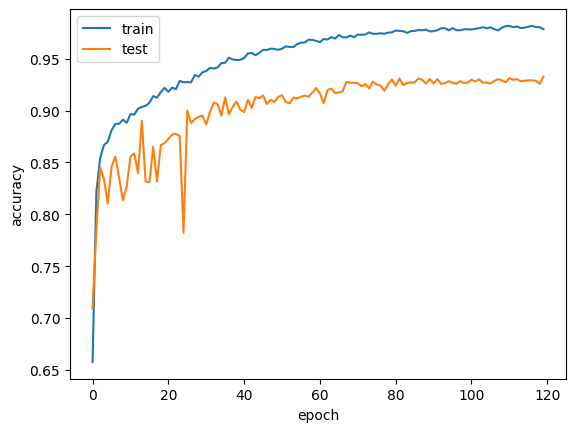

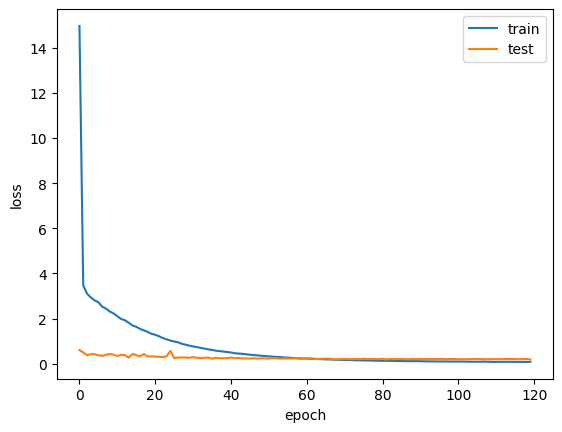

In [17]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [18]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCars_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_exp_mixed_L1_L2.csv')

In [19]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.657632,0.709306,14.970767,0.601970
1,0.821683,0.784942,3.465794,0.498118
2,0.854234,0.845126,3.103550,0.372515
3,0.866749,0.834205,2.934389,0.420233
4,0.869926,0.810271,2.806006,0.418786


In [20]:
print(df["test_acc"].max())

0.932729173928198
